In [28]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import class_weight

import re
from datetime import date, datetime

In [2]:
base_dir = './images_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# directory to training bot pictures
train_bot_dir = os.path.join(train_dir, '1_bot')

# directory to training human pictures
train_human_dir = os.path.join(train_dir, '0_human')

# directory to validation bot pictures
val_bot_dir = os.path.join(val_dir, '1_bot')

# directory to validation human pictures
val_human_dir = os.path.join(val_dir, '0_human')

#directory to test bot pictures
test_bot_dir = os.path.join(test_dir, '1_bot')

#directory to test human pictures
test_human_dir = os.path.join(test_dir, '0_human')


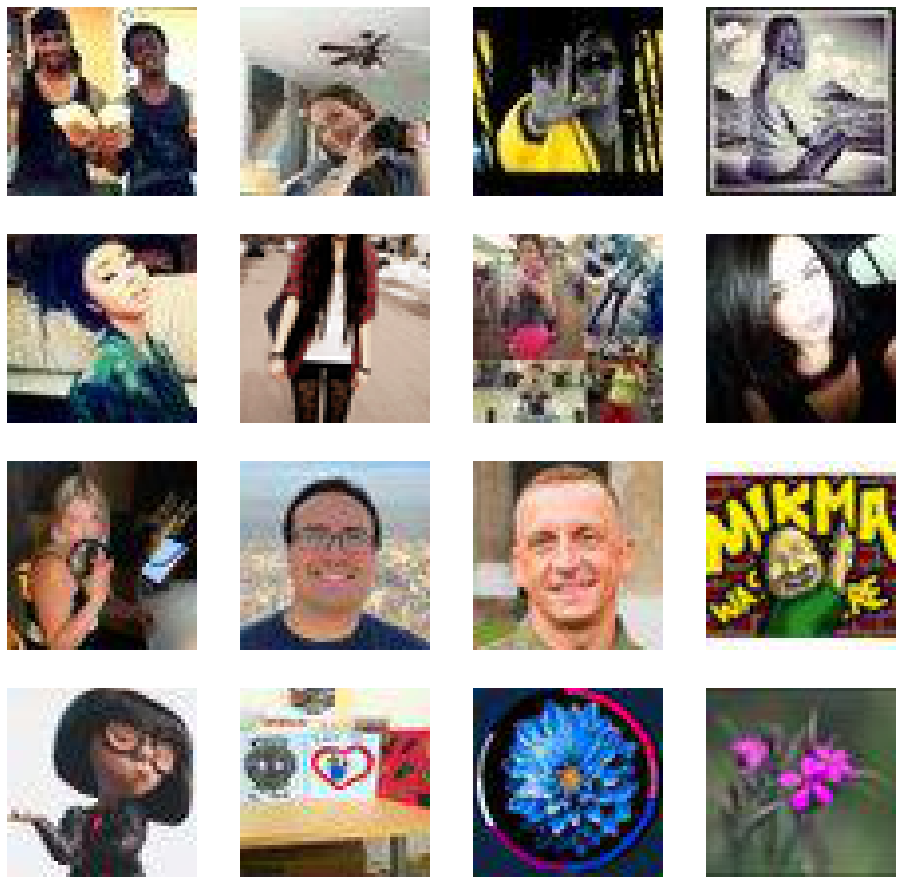

In [3]:
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_bot_fnames = os.listdir(train_bot_dir)
train_human_fnames = os.listdir(train_human_dir)


next_bot_pix = [os.path.join(train_bot_dir, fname) 
                for fname in train_bot_fnames[ pic_index-8:pic_index]]

next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_bot_pix+next_human_pix):
    # set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [5]:
# import the InceptionV3 model  
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

# freeze layers
for layer in pre_trained_model.layers:
    layer.trainable = False

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.959):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

87910968/87910968 [==============================] - 10s 0us/step


In [6]:
# flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)

# add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(2500, activation='tanh')(x)

# add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(2500, activation='relu')(x)

# add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)    

# add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

from tensorflow import keras
from keras.metrics import Accuracy
from keras.metrics import Precision
from keras.metrics import Recall

metrics = [
    #keras.metrics.Accuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]


model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc', metrics])

In [7]:
# add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   #zoom_range = 0.2,
                                   horizontal_flip = True)

# validation data should not be augmented
val_datagen = ImageDataGenerator(rescale = 1.0/255.)

# flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# flow validation images in batches of 32 using val_datagen generator
val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size  = 32,
                                                class_mode  = 'binary', 
                                                target_size = (150, 150))

Found 8150 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.


In [15]:
tmp = next(train_generator)
tmp[1].shape

(32,)

In [90]:
%%time

# with optimizer = Adam   
# callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2,
            # callbacks=[callbacks], 
            shuffle = True)

Epoch 1/20
100/100 - 288s - loss: 0.9563 - acc: 0.6941 - val_loss: 0.6020 - val_acc: 0.7181 - 288s/epoch - 3s/step
Epoch 2/20
100/100 - 318s - loss: 0.5707 - acc: 0.7355 - val_loss: 0.5691 - val_acc: 0.7200 - 318s/epoch - 3s/step
Epoch 3/20
100/100 - 339s - loss: 0.5570 - acc: 0.7372 - val_loss: 0.5733 - val_acc: 0.7256 - 339s/epoch - 3s/step
Epoch 4/20
100/100 - 310s - loss: 0.5618 - acc: 0.7216 - val_loss: 0.5507 - val_acc: 0.7425 - 310s/epoch - 3s/step
Epoch 5/20
100/100 - 293s - loss: 0.5592 - acc: 0.7256 - val_loss: 0.5647 - val_acc: 0.7262 - 293s/epoch - 3s/step
Epoch 6/20
100/100 - 303s - loss: 0.5493 - acc: 0.7427 - val_loss: 0.5601 - val_acc: 0.7237 - 303s/epoch - 3s/step
Epoch 7/20
100/100 - 332s - loss: 0.5631 - acc: 0.7250 - val_loss: 0.5690 - val_acc: 0.7225 - 332s/epoch - 3s/step
Epoch 8/20
100/100 - 345s - loss: 0.5551 - acc: 0.7266 - val_loss: 0.5798 - val_acc: 0.7281 - 345s/epoch - 3s/step
Epoch 9/20
100/100 - 327s - loss: 0.5418 - acc: 0.7378 - val_loss: 0.5397 - val_

In [152]:
counts = pd.DataFrame(train_generator.classes).value_counts()
print(counts)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
print(weight_for_0)
print(weight_for_1)

0    4853
1    3297
dtype: int64
0.000206058108386565
0.00030330603579011223


In [153]:
%%time

# with optimizer = Adam  
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = val_generator,
            #steps_per_epoch = 100,
            epochs = 20,
            #validation_steps = 50,
            verbose = 2,
            # callbacks=[callbacks],  
            class_weight = {0 : weight_for_0, 1 : weight_for_1})

Epoch 1/20
255/255 - 712s - loss: 1.7307e-04 - acc: 0.6221 - precision: 0.5280 - recall: 0.6197 - val_loss: 0.5738 - val_acc: 0.7252 - val_precision: 0.6557 - val_recall: 0.6748 - 712s/epoch - 3s/step
Epoch 2/20
255/255 - 596s - loss: 1.5619e-04 - acc: 0.6518 - precision: 0.5597 - recall: 0.6530 - val_loss: 0.5974 - val_acc: 0.6850 - val_precision: 0.5797 - val_recall: 0.8034 - 596s/epoch - 2s/step
Epoch 3/20
255/255 - 551s - loss: 1.4735e-04 - acc: 0.6855 - precision: 0.5967 - recall: 0.6867 - val_loss: 0.5578 - val_acc: 0.7174 - val_precision: 0.7296 - val_recall: 0.4782 - 551s/epoch - 2s/step
Epoch 4/20
255/255 - 556s - loss: 1.4383e-04 - acc: 0.6881 - precision: 0.5977 - recall: 0.7003 - val_loss: 0.5406 - val_acc: 0.7252 - val_precision: 0.7308 - val_recall: 0.5073 - 556s/epoch - 2s/step
Epoch 5/20
255/255 - 570s - loss: 1.3980e-04 - acc: 0.7071 - precision: 0.6196 - recall: 0.7149 - val_loss: 0.5693 - val_acc: 0.7036 - val_precision: 0.7670 - val_recall: 0.3835 - 570s/epoch - 2s/

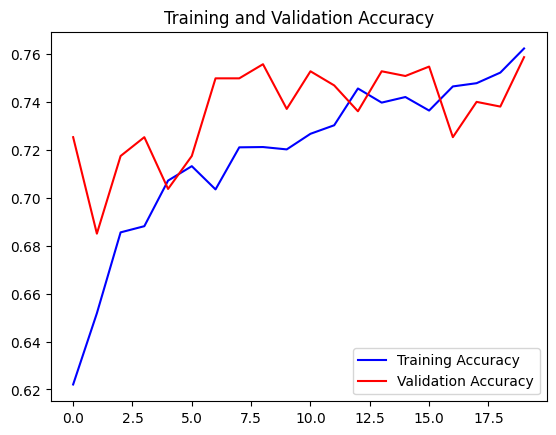

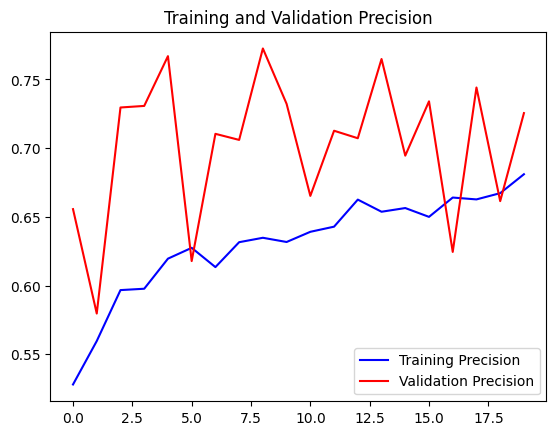

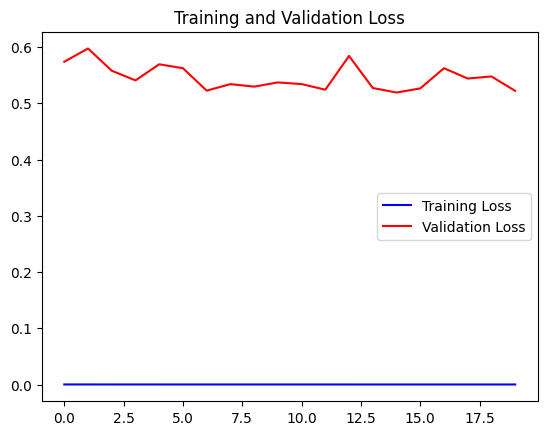

In [155]:
# with optimizer = Adam 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'b', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [177]:
base_dir = './images_split'
test_dir = os.path.join(base_dir, 'test')

# directory to test bot pictures
test_bot_dir = os.path.join(test_dir, '1_bot')

# directory to test human pictures
test_human_dir = os.path.join(test_dir, '0_human')

# test data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# flow test images in batches of 32 using test_datagen generator
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size  = 32,
                                                   class_mode  = 'binary', 
                                                   target_size = (150, 150), 
                                                   shuffle = False) 

Found 1015 images belonging to 2 classes.


In [178]:
model.evaluate(test_generator)

32/32 [==============================] - 38s 1s/step - loss: 0.5321 - acc: 0.7448 - precision: 0.6915 - recall: 0.6731


[0.5321333408355713,
 0.7448275685310364,
 0.6915422677993774,
 0.6731234788894653]

In [179]:
yhat_probs = model.predict(test_generator)
y_pred = [1 if y >= 0.5 else 0 for y in yhat_probs]

32/32 [==============================] - 41s 1s/step


In [185]:
test_generator.class_indices

{'0_human': 0, '1_bot': 1}

In [182]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(test_generator.classes, y_pred)
f1 = f1_score(test_generator.classes, y_pred)
precision = precision_score(test_generator.classes, y_pred)
recall = recall_score(test_generator.classes, y_pred)
report = classification_report(test_generator.classes, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Classification Report: \n {report}')

Accuracy: 0.7448275862068966
F1-score: 0.6822085889570552
Precision: 0.6915422885572139
Recall: 0.6731234866828087
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.79      0.79       602
           1       0.69      0.67      0.68       413

    accuracy                           0.74      1015
   macro avg       0.74      0.73      0.73      1015
weighted avg       0.74      0.74      0.74      1015



In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_generator.classes, y_pred))
disp.plot(cmap = "Blues")
plt.show()

# Combining with metadata

In this section, we shall build a model that combines both the structured account features with the profile image data to see if prediction power is augmented by combining both kinds of data.

In [ ]:
#First, we shall read in the data for the accounts from both sides


In [50]:
validationids = val_bot_account_names + val_human_account_names

In [53]:
validationdata = meta_data[meta_data.id.isin(validationids)]

In [54]:
validationdata.sort_values('id').isBot

17392    0
10828    0
9089     0
6822     0
1661     0
        ..
11866    1
6526     1
8809     1
19637    1
7014     1
Name: isBot, Length: 1022, dtype: int64

In [56]:
#make the images into tensors
# flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 8150,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# flow validation images in batches of 32 using val_datagen generator
val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size  = 1019,
                                                class_mode  = 'binary', 
                                                target_size = (150, 150),
                                               shuffle = False)

Found 8150 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.


In [57]:
X_val, y_val = val_generator.next()

In [58]:
y_val

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [42]:
human = 0
bot = 0
for i in y_val:
    if i == 1:
        bot+= 1
    else:
        human += 1
print(human, bot)

607 412


In [8]:
#Next, we extract the ids of all the bots and humans 

train_bot_fnames = os.listdir(train_bot_dir)
train_human_fnames = os.listdir(train_human_dir)
val_bot_fnames = os.listdir(val_bot_dir)
val_human_fnames = os.listdir(val_human_dir)
test_bot_fnames = os.listdir(test_bot_dir)
test_human_fnames = os.listdir(test_human_dir)



In [9]:
def bot_name_process(text):
    text = text.replace("./images_split\\train\\1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account

training_bot_account_names = list(map(bot_name_process,train_bot_fnames))

In [10]:
def human_name_process(text):
    text = text.replace("./images_split\\train\\0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account

training_human_account_names = list(map(human_name_process,train_human_fnames))

In [11]:
def val_human_name_process(text):
    text = text.replace("./images_split\\val\\0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account
    
val_human_account_names = list(map(val_human_name_process,val_human_fnames))

In [12]:
def val_bot_name_process(text):
    text = text.replace("./images_split\\val\\1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account
val_bot_account_names = list(map(val_bot_name_process,val_bot_fnames))

In [13]:
#finally, extracting the ids from the test set
def test_bot_name_process(text):
    text = text.replace("./images_split\\test\\1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account
test_bot_account_names = list(map(test_bot_name_process,test_bot_fnames))

In [14]:
#finally, extracting the ids from the test set
def test_human_name_process(text):
    text = text.replace("./images_split\\test\\0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account
test_human_account_names = list(map(test_human_name_process,test_human_fnames))

In [15]:
all_ids = training_bot_account_names + training_human_account_names + val_bot_account_names + val_human_account_names + test_bot_account_names + test_human_account_names

In [16]:
#Extracting relevant rows
meta_data = pd.read_csv('final_combined_dataset.csv')

In [18]:
accounts_w_profile_pic = meta_data[meta_data.id.isin(all_ids)]


In [19]:
def url(df):
    df["has_url"] = ~df["url"].isna()
    return df

def username(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["un_no_of_char"] = df["username"].apply(lambda x: len(str(x)))
    df["un_special_char"] = df["username"].apply(lambda x: special_char.search(str(x)) != None)
    return df

def name(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["name_no_of_char"] = df["name"].apply(lambda x: len(str(x)))
    df["name_special_char"] = df["name"].apply(lambda x: special_char.search(str(x)) != None)
    return df

def description(df):
    user_tags = r'\B@\w*[a-zA-Z]*\w*'
    hashtags = r'\B#\w*[a-zA-Z]+\w*'
    links = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
    df["des_no_of_usertags"] = df["description"].apply(lambda x: len(re.findall(user_tags, str(x)))) #str(x).count('@'))
    df["des_no_of_hashtags"] = df["description"].apply(lambda x: len(re.findall(hashtags, str(x)))) #str(x).count('#'))
    df["des_external_links"] = df["description"].apply(lambda x: re.findall(links, str(x)) != [])
    df["has_description"] = ~df["description"].isna() 
    return df

def location(df):
    df["location"] = ~df["location"].isna() # false = location is NaN; true = has location
    return df
  
def time(df):
    # df["created_time"] = df["created_at"].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date())
    # d1 = date(2022, 10, 8) # date we extracted these data 
    df["account_age_in_days"] = df["created_at"].apply(lambda x : (date(2022, 10, 8) - datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date()).days)
    df["average_tweets_per_day"] = df["tweet_count"]/df["account_age_in_days"]
    return df

def follow_count(df):
    df["followers_following_count"] = df["followers_count"] * df["following_count"]
    return df

def account_type(df):
    df["isBot"] = df["account_type"].apply(lambda x : 1 if x == 'bot' else 0)
    return df

def convert_PV(variable):
    if variable == 'True':
        return True
    if variable == 'False':
        return False
    if variable == '0.0':
        return False
    if variable == '1.0':
        return True
    return variable

def convert_TF(variable):
    var = 1 if variable == True else 0
    return var

In [29]:
meta_data = account_type(meta_data)
meta_data = username(meta_data)
meta_data = name(meta_data)
meta_data = description(meta_data)
meta_data = location(meta_data)
meta_data = url(meta_data)
meta_data = time(meta_data)
meta_data = follow_count(meta_data)

pv_var = ["verified", "protected"]

for var in pv_var:
    meta_data[var] = meta_data[var].apply(convert_PV)

boolean_var = ["verified", "location", "un_special_char", 
               "name_special_char", "des_external_links", 
               "has_description", "protected", 
               "has_url", "has_profile_image"]

for var in boolean_var:
    meta_data[var] = meta_data[var].apply(convert_TF)
    
int_var = ["followers_count", "following_count", "tweet_count", "listed_count"]

for var in int_var:
    meta_data[var] = meta_data[var].astype(int)

In [32]:
processed_metadata = meta_data.drop(columns=["Unnamed: 0", "url", "id", "created_at", "name", "username", "description", "profile_image_url", "account_type"])

In [33]:
processed_metadata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,isBot,un_no_of_char,...,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,account_age_in_days,average_tweets_per_day,followers_following_count
0,0,0,1,1959,2708,405158,157,1,0,6,...,12,0,0,0,0,1,1,5049,80.245197,5304972
1,0,0,1,371,0,33172,10,1,0,13,...,14,0,0,0,0,1,1,4822,6.879303,0
2,0,0,1,36,0,548,0,1,1,13,...,16,0,0,0,0,1,0,4041,0.135610,0
3,0,0,1,30,148,93,1,1,1,12,...,12,0,0,0,0,1,1,3138,0.029637,4440
4,0,0,1,1089,2283,9098,34,1,0,10,...,14,0,0,0,1,1,1,5069,1.794831,2486187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20284,0,0,1,72,76,4161,1,1,0,11,...,12,0,0,0,0,0,0,5204,0.799577,5472
20285,0,0,1,314,107,20915,9,1,0,13,...,14,0,0,0,1,1,1,5094,4.105811,33598
20286,0,0,1,2981,2523,4991,46,1,0,14,...,16,0,0,3,1,1,1,4971,1.004023,7521063
20287,0,0,1,170,180,7820,4,1,0,11,...,12,0,0,0,0,1,0,5224,1.496937,30600


In [34]:
actual_metadata = pd.read_csv('../Model (Metadata)/train_dataset.csv')

In [35]:
actual_metadata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,isBot
0,0,0,0,-0.058996,-0.101765,-0.375390,-0.064435,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,1
1,0,0,0,-0.058509,-0.061982,-0.024002,-0.064274,1,-0.277500,0,-1.193893,0,-0.264936,-0.226362,0,1,0,0
2,0,0,1,-0.058917,-0.092427,-0.206857,-0.062335,1,0.094003,0,0.467797,0,-0.264936,-0.226362,0,1,1,0
3,0,0,1,-0.057353,0.078232,-0.321707,-0.059427,1,1.580014,0,0.098533,0,6.295222,-0.226362,1,1,1,0
4,0,0,1,-0.058873,-0.094191,-0.207697,-0.064112,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16226,0,1,1,0.183041,2.307269,0.000665,-0.002560,1,1.580014,1,0.652429,0,-0.264936,-0.226362,1,1,1,1
16227,0,0,1,-0.058544,-0.093461,-0.219648,-0.057004,1,-0.277500,0,1.390958,0,-0.264936,-0.226362,0,1,0,0
16228,0,0,1,-0.058863,-0.095256,-0.194927,-0.062820,1,1.208511,0,0.652429,0,-0.264936,-0.226362,0,1,1,0
16229,0,0,0,-0.058952,-0.071228,-0.375411,-0.064274,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,1
